In [1]:
import os
os.environ['OMP_NUM_THREADS']='4'

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

from dolfin import *

import sys
sys.path.insert(0, '../../')
from reaktoro_transport.solver import stokes_uzawa

#importing the class
from reaktoro_transport.physics.DG0Kernel import DG0Kernel
from reaktoro_transport.problem.TracerTransportProblem import TracerTransportProblem
from reaktoro_transport.problem.StokesFlowUzawa import StokesFlowUzawa

from ufl.algebra import Abs

%matplotlib inline
plt.rcParams.update({'font.size': 18})
plt.rc('text', usetex = True)
plt.rc('font', **{'family' : "sans-serif"})
plt.rcParams.update({'text.latex.preamble' : [r'\usepackage{siunitx}', r'\usepackage{amsmath}']})

In [2]:
def transient_adv_diff_DG(mesh, boundary_markers, adv, source, D_num, init_cond, dt_num, steps, theta_num):
    # Input
    # mesh:     dolfin mesh

    # Output
    # u_list:   list of dolfin function

    V = FunctionSpace(mesh, 'DG', 0)
    Vec = VectorFunctionSpace(mesh, 'CR', 1)

    u = TrialFunction(V)
    w = TestFunction(V)
    u0 = project(init_cond, V)

    n = FacetNormal(mesh)

    x_ = interpolate(Expression("x[0]", degree=1), V)
    y_ = interpolate(Expression("x[1]",degree=1), V)

    Delta_h = sqrt(jump(x_)**2 + jump(y_)**2)
    adv = project(adv, Vec)

    ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)
    dS = Measure('dS', domain=mesh, subdomain_data=boundary_markers)

    u_list = [u0.copy()]

    bc = []

    dt = Constant(dt_num)
    one = Constant(1.0)

    adv_np = ( dot ( adv, n ) + Abs ( dot ( adv, n ) ) ) / 2.0
    adv_nm = ( dot ( adv, n ) - Abs ( dot ( adv, n ) ) ) / 2.0
    adv_n = dot ( adv, n )

    def L(w, u):
        return Constant(D_num)*dot(jump(w), jump(u))/Delta_h*dS(0) \
               + dot(jump(w), adv_np('+')*u('+') - adv_np('-')*u('-') )*dS(0) \
               + w*u/x_*ds(2) \
               + w*inner(adv_np, u)*ds(3) # Outflow boundary conditions
               

        #return dot(jump(w), adv_np('+')*u('+') - adv_np('-')*u('-') )
        #return Constant(0.5)*w*div(adv*u) + Constant(0.5)*w*dot(adv, grad(u))


    delta_u = u - u0
    W = 0.5
    #ww = (w*source-L(w, u0))

    #F = (w*delta_u/dt + W*L(w, u - u0) - ww)*dx

    #a, L = lhs(F), rhs(F)

    theta = Constant(theta_num)

    a = ( w*u/dt )*dx + theta*L(w, u)
    L = ( w*u0/dt + w*source )*dx - (one-theta)*L(w, u0) + w*one/x_*ds(2)
    u = Function(V)

    problem = LinearVariationalProblem(a, L, u, bcs=bc)
    solver = LinearVariationalSolver(problem)

    prm = solver.parameters

    prm['krylov_solver']['absolute_tolerance'] = 1e-12
    prm['krylov_solver']['relative_tolerance'] = 1e-10
    prm['krylov_solver']['maximum_iterations'] = 500
    #if iterative_solver:
    prm['linear_solver'] = 'gmres'
    prm['preconditioner'] = 'ilu'

    for i in range(steps):
        solver.solve()
        u0.assign(u)
        u_list.append(u0.copy())

    return u_list


In [3]:
class tracer_transport_problem(TracerTransportProblem, StokesFlowUzawa, DG0Kernel):
    """"""
    
    def set_flow_field(self, file_path):
        V = VectorFunctionSpace(self.mesh, "Crouzeix-Raviart", 1)
        #Q = FunctionSpace(self.mesh, "DG", 0)
        self.fluid_velocity = Function(V)
        
        xdmf_obj = XDMFFile(MPI.comm_world, file_path)
        xdmf_obj.read_checkpoint(self.fluid_velocity, 'velocity', 0)
        xdmf_obj.close()


In [4]:
# Reading mesh and MeshFunction that stores the fluid solid markers
mesh_xdmf = Mesh()

xdmf_obj = XDMFFile(MPI.comm_world, '../2_flow_simulation/fluid_mesh.xdmf')
xdmf_obj.read(mesh_xdmf)

domain_markers = MeshFunction('size_t', mesh_xdmf, dim=2)
xdmf_obj.read(domain_markers)

xdmf_obj.close()


boundary_markers = MeshFunction('size_t', mesh_xdmf, dim=1)
xdmf_obj = XDMFFile(MPI.comm_world, '../2_flow_simulation/fluid_boundary.xdmf')
xdmf_obj.read(boundary_markers)
xdmf_obj.close()

In [5]:
p_bc_dict = {'inlet': [2, 3, 4], 'noslip': [4], }
p_dirichlet_list = [Constant(1.0), Constant(1.0), Constant(0.0)]

In [6]:
%%time

problem = tracer_transport_problem()
problem.set_mesh(mesh_xdmf)
problem.set_boundary_markers(boundary_markers)
problem.set_domain_markers(domain_markers)

problem.set_flow_field(file_path = '../2_flow_simulation/pv_output_fluid_mesh.xdmf')
#problem.set_pressure_boundary_conditions(p_bc_dict, p_dirichlet_list)
#velocity, pressure = problem.solve_stokes(max_steps=50, res_target=1e-13, omega_num=500.0, r_num=400.0)

CPU times: user 24.1 ms, sys: 886 µs, total: 25 ms
Wall time: 24.6 ms


In [7]:
problem.set_components('Na+', 'Cl-')
problem.set_component_fe_space()
problem.initialize_form()
problem.set_component_ics([Expression('0.0', degree=0), Expression('0.0', degree=0)])

In [8]:
problem.add_advection(marker=0)
problem.add_diffusion('Na+', diffusivity=1e-3, marker=0)
problem.add_diffusion('Cl-', diffusivity=8e-4, marker=0)

In [9]:
problem.mark_component_boundary(**{'Na+': [2, 3], 'Cl-': [2, 3], 'outlet': [4]})
problem.add_component_bc('Na+', [Constant(1.0), Constant(1.0)])
problem.add_component_bc('Cl-', [Constant(1.0), Constant(1.0)])
problem.add_outflow_bc()
problem.generate_solver()

In [10]:
problem.set_output_instance('tracer_transport_fluid_mesh')

In [11]:
%%time

solution = problem.solve_transport(dt_val=3.0, timesteps=180)

CPU times: user 11.2 s, sys: 14 s, total: 25.2 s
Wall time: 6.33 s


In [12]:
problem.delete_output_instance()

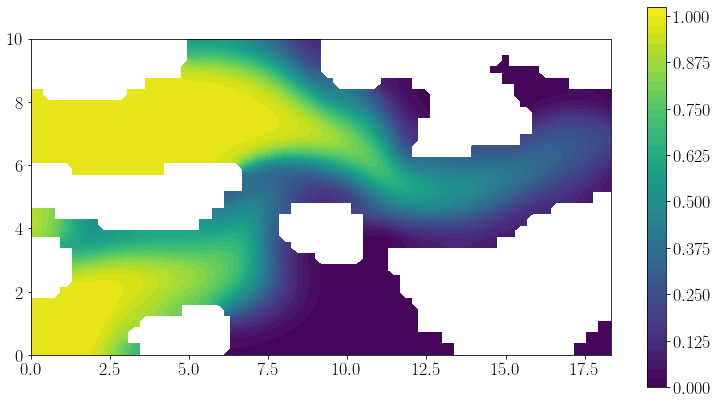

In [13]:
fig = plt.figure(figsize=(13,7))
cb = plot(solution[0])
fig.colorbar(cb)
plt.show()